# Project HRV fatigue

In [16]:
###########################
### package importation ###
###########################

import glob
import wfdb
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import detrend, butter, lfilter, freqz, hilbert, find_peaks, find_peaks_cwt
from statsmodels.tsa.stattools import ccf
import seaborn as sns
from scipy import fftpack
from sklearn.cluster import KMeans
import scipy.spatial.distance as ssd 
import scipy.stats as ss

sns.set_style("darkgrid") # style for the plots

# Function definition

Here we will define some functions that we will use later.

In [17]:
def read(file):
    '''
    Read a .hea file and convert it to a dataframe
    '''
    
    w = wfdb.rdsamp(file) # using the builtin function of PhysioNet package 'wfdb'
    # The line was designed for database/wrist  
    return(pd.DataFrame(data=w[0][:, :2], columns={'ECG', 'PPG'})) # saving data as a DataFrame (see Pandas)

In [18]:
def creating_dataframe(file):
    '''
    Creating a DataFrame (sea Pandas) with the data from the .hea file. We also add 'detrend' data.
    '''
    
    ##########################
    ### creating DataFrame ###
    ##########################
    
    print("Reading and saving as dataframe: " + file + "\n")
    df_temp = read(file) # acces data from .hea file
    df_temp = df_temp.dropna() # drop Na
    
    ############################
    ### adding no trend data ###
    ############################
    
    print("Adding no trend data\n")
    for col in {'ECG', 'PPG'}: # creating 'no trend' data
        temp = df_temp[col] - df_temp[col].mean() # removing the mean 
        df_temp[col + '_no_trend'] = detrend(temp.values) # removing linear trend
    return(df_temp)

In [19]:
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

In [20]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [21]:
def add_butter_filter(df, lowcut, highcut, fs, order):
    '''
    Add butter filter
    '''
   
    ############################
    ### adding butter filter ###
    ############################
    
    print("Adding butter filter with lowcut of " + str(lowcut) + " Hz" + " and highcut of " + str(highcut) + " Hz\n")
    for col in {'ECG', 'PPG'}: # butter on no trend data !
         #df[col + '_butter_' + str(lowcut) + '_' + str(highcut)] = butter_bandpass_filter(
         #                                                         df[col + '_no_trend'].values, lowcut, highcut,
         #                                                         fs, order)
        df[col + '_butter_'] = butter_bandpass_filter(df[col + '_no_trend'].values, lowcut, highcut, fs, order)
    return(df)

In [22]:
def add_hilbert(df):
    '''
    Add Hilbert transform, see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html.
    '''
   
    ################################
    ### adding Hilbert transform ###
    ################################
    
    print("Add Hilbert transform")
    for col in {'ECG', 'PPG'}: # Hilbert on no trend data !
        temp = hilbert(df[col + '_no_trend'].values)
        df[col + '_hilbert_envelope'] = np.abs(temp)
        df[col + '_hilbert_phase'] = np.unwrap(np.angle(temp))
        temp_2 = list((np.diff(df[col + '_hilbert_phase'].values) / (2.0 * np.pi) * frequency_sampling))
        temp_2.append(0)
        df[col + '_hilbert_frequency'] = temp_2
    cols = [col for col in df.columns if '_butter_' in col] # Hilbert on band pass filtered data !
    for col in cols: 
        temp = hilbert(df[col].values)
        df[col + '_hilbert_envelope'] = np.abs(temp)
        df[col + '_hilbert_phase'] = np.unwrap(np.angle(temp))
        temp_3 = list((np.diff(df[col + '_hilbert_phase'].values) / (2.0 * np.pi) * frequency_sampling))
        temp_3.append(0)
        df[col + '_hilbert_frequency'] = temp_3
    return(df)

In [23]:
def plot_fourier(data, windows_freq_min=None, windows_freq_max=None, log_scale=False):
    '''
    Plot the Fourier transform of data. Windows threshold must be given in Hz.
    '''
    
    #########################
    ### Fourier transform ###
    #########################

    data_fourier = fftpack.fft(data)
    freqs = fftpack.fftfreq(len(data)) * frequency_sampling
    df_temp = pd.DataFrame(data={'freqs': freqs, 'abs(fourier)': np.abs(data_fourier)})
    plt.figure(figsize=(15, 7))
    if windows_freq_min != None and windows_freq_min != None:
        df_temp = df_temp[(windows_freq_min <= df_temp.freqs) & (df_temp.freqs <= windows_freq_max)]
        plt.xlim(windows_freq_min, windows_freq_max)
    elif windows_freq_min != None:
        df_temp = df_temp[windows_freq_min <= df_temp.freqs]
        plt.xlim(left=windows_freq_min) 
    elif windows_freq_max != None:
        df_temp = df_temp[df_temp.freqs <= windows_freq_max]
        plt.xlim(right=windows_freq_max)   
    if log_scale:
        plt.loglog(df_temp.freqs, df_temp['abs(fourier)']) 
        plt.grid(True,which="both",ls="-")
    else:
        plt.plot(df_temp.freqs, df_temp['abs(fourier)']) 
    plt.title('Fourier transform of ' + data.name)
    plt.xlabel('frequency in Hertz [Hz]')
    plt.ylabel('power density')
    plt.show()

In [24]:
def plot_cross_correlation(df, tau, windows_low_x=None, windows_high_x=None):
    '''
    Plot cross-correlation of 2 time series.
    '''
    
    #########################
    ### cross correlation ###
    #########################
    
    data_1 = df.ECG_no_trend.values
    data_2 = df.PPG_no_trend.values
    taui = np.floor(tau * frequency_sampling)
    taui = taui.astype(int)+1
    time = np.linspace(0, np.shape(data_1)[0] / frequency_sampling, np.shape(data_1)[0])
    plt.figure(figsize=(15, 7))
    plt.plot(time[:-taui], ccf(data_1[taui:], data_2[:-taui]))
    plt.title("Cross-correlation of " + df.ECG.name + " and " + df.PPG.name)
    if windows_low_x != None and windows_high_x != None:
        plt.xlim(windows_low_x, windows_high_x)
    elif windows_low_x != None:
        plt.xlim(left=windows_low_x)
    elif windows_high_x != None:
        plt.xlim(right=windows_high_x)
    plt.xlabel("time in second [s]")
    plt.ylabel("correlation")
    plt.show()

In [25]:
def plot_correlation_map(df):
    '''
    Plot correlation map.
    '''
    
    #######################
    ### correlation map ###
    #######################
    
    corr = df.apply(np.abs).corr(method = 'pearson')
    return(corr.style.background_gradient(cmap='coolwarm').set_precision(2))

In [26]:
def plot_dataframe(df, windows_low_x, windows_high_x, windows_low_y, windows_high_y, mask='all'):
    '''
    Plot a dataframe. You can provide a mask with a list, for instance: mask = ['PPG', 'ECG'].
    '''
    
    ######################
    ### DataFrame plot ###
    ######################
    
    time = np.linspace(0, np.shape(df.PPG.values)[0] / frequency_sampling, np.shape(df.PPG.values)[0])
    plt.figure(figsize=(15, 7))
    if mask=='all':
        for counter, col in enumerate(df.columns):
            plt.plot(time, df[col] - counter*df[col].apply(np.sqrt), label=col)
    else:
        for col in mask:
            if col == 'ECG':
                plt.plot(time, df[col + '_no_trend'] + df[col + '_no_trend'].apply(np.abs).mean(), label=col)
            if col == 'PPG':
                plt.plot(time, df[col + '_no_trend'], label=col)
            elif col != 'ECG' and col !='PPG':
                plt.plot(time, df[col ], label=col)
            
    plt.legend()
    plt.xlabel("time in second [s]")
    plt.ylabel("potential [mV]")
    plt.xlim([windows_low_x, windows_high_x])
    plt.ylim([windows_low_y, windows_high_y])
    plt.title('Multiple plot')
    plt.show()

In [75]:
def plot_peak(data, dist, windows_low_x=None, windows_high_x=None):
    '''
    Finding peaks with scipy package
    '''
    
    #####################
    ### finding peaks ###
    #####################
    
    peaks, properties = find_peaks(data, distance=dist*frequency_sampling)
    plt.figure(figsize=(18, 7))
    time = np.linspace(0, np.shape(data)[0] / frequency_sampling, np.shape(data)[0])
    plt.plot(time, data)
    plt.plot(time[peaks], data[peaks], "o")
    if windows_low_x != None and windows_high_x != None:
        plt.xlim(windows_low_x, windows_high_x)
    elif windows_low_x != None:
        plt.xlim(left=windows_low_x)
    elif windows_high_x != None:
        plt.xlim(right=windows_high_x)
    plt.title("Finding peaks of " + data.name)
    plt.xlabel('time in second [s]')
    plt.ylabel('potential [mV]')
    plt.show()
    
        
    #########################################################
    ### computing intervals and increments between peaks ###
    #########################################################
    
    intervalle = time[peaks[1:]] - time[peaks[:-1]] 
    intervalle_cluster = pd.DataFrame(intervalle)
    increment = data.values[peaks[1:]] - data.values[peaks[:-1]] 
    
    #######################
    ### Cluster K-means ###
    #######################
    
    model = KMeans(n_clusters=3) # create the model
    model.fit(intervalle_cluster) # fit the model with our data
    colormap = np.array(['Red','green','blue'])
    
    
    ################
    ### Plotting ###
    ################

    plt.figure(figsize=(15, 7))
    plt.scatter(time[peaks[:-1]],
                intervalle_cluster, c=colormap[model.labels_])
    plt.title("Interval between peaks of " + data.name + ' (clustered using Kmeans method)')
    plt.xlabel('time in [s]')
    plt.ylabel('interval in second [s]')
    plt.show()
    
    plt.figure(figsize=(15, 7))
    plt.hist(intervalle, bins=100)
    plt.title("Distribution of the intervals between peaks of " + data.name)
    plt.xlabel('interval in second [s]')
    plt.ylabel('frequency')
    plt.show()
    
    plt.figure(figsize=(15, 7))
    plt.plot(time[peaks[:-1]],increment)
    plt.title("Increments between peaks of " + data.name)
    plt.xlabel('time in [s]')
    plt.ylabel('increments in potential [mV]')
    plt.show()
    
    plt.figure(figsize=(15, 7))
    plt.hist(increment, bins=100)
    plt.title("Distribution of the increments between peaks of " + data.name)
    plt.xlabel('increments in potential [mV]')
    plt.ylabel('frequency')
    plt.show()
    
    return peaks, intervalle, increment


In [84]:
def plot_peak_corr(peaks_1, peaks_2):
    '''
    plotting peaks of one signal with respect to the ones of another signal
    '''
    
    max_indice = min(len(peaks_1), len(peaks_2))
    peaks_1_temp = peaks_1[:max_indice]
    peaks_2_temp = peaks_2[:max_indice]
    
    ################
    ### Plotting ###
    ################
    
    plt.figure(figsize=(15, 7))
    plt.plot(peaks_1_temp / frequency_sampling, peaks_2_temp / frequency_sampling)
    # plt.plot(peaks_1_temp / frequency_sampling, peaks_1_temp / frequency_sampling)
    plt.title('Distances correlation between the two signals')
    plt.xlabel('peaks times for signal 1 in second [s]')
    plt.ylabel('peaks times for signal 2 in second [s]')
    plt.show()
    
    print('distance measure based on correlation between the two vectors: ',
          ssd.correlation(peaks_1_temp, peaks_2_temp) )# Computes a distance measure based on correlation between the two vectors
    print ('correlation matrix: \n',
           np.corrcoef(peaks_1_temp, peaks_2_temp)) # Gives back the correlation matrix for the two arrays
    print ('spearman correlation: ', 
           ss.spearmanr(peaks_1_temp, peaks_2_temp)) # Gives the spearman correlation for the two arrays

# Data processing 

In this part we prepare the data from [Physionet](https://physionet.org/) to be used during this project. All data have the same frequency sampling: **256**.

In [28]:
print("All the files available:\n")
hea_file = []
for file in glob.glob("Data/*.hea"): # print all file in the 'Data' folder with .hea as extension
    hea_file.append(file[:-4]) # list of all files, can be used in the 'read' function
    print(file[5:-4]) 

All the files available:

s2_low_resistance_bike
s6_run
s6_low_resistance_bike
s5_run
s2_walk
s3_walk
s8_walk
s9_walk
s5_low_resistance_bike
s4_run
s1_low_resistance_bike
s1_high_resistance_bike
s6_walk
s8_run
s3_high_resistance_bike
s3_low_resistance_bike
s2_high_resistance_bike
s3_run
s1_walk


All files' names has been saved in a list: **hea_file**. 

In [29]:
frequency_sampling = 256 # set the frequency variable
df = creating_dataframe(hea_file[4]) # creat a dataframe from hea_list
df = add_butter_filter(df, 0.3, 4, frequency_sampling, 3) # add butter filter with ECG_no_trend, PPG_no_trend
df = add_hilbert(df) # add Hilbert transform with ECG_no_trend, PPG_no_trend, ECG_butter, PPG_butter
print("\nFinal DataFrame:")
df.iloc[105:110] # display 5 elements

Reading and saving as dataframe: Data/s2_walk

Adding no trend data

Adding butter filter with lowcut of 0.3 Hz and highcut of 4 Hz

Add Hilbert transform

Final DataFrame:


,PPG,ECG,PPG_no_trend,ECG_no_trend,PPG_butter_,ECG_butter_,PPG_hilbert_envelope,PPG_hilbert_phase,PPG_hilbert_frequency,ECG_hilbert_envelope,ECG_hilbert_phase,ECG_hilbert_frequency,PPG_butter__hilbert_envelope,PPG_butter__hilbert_phase,PPG_butter__hilbert_frequency,ECG_butter__hilbert_envelope,ECG_butter__hilbert_phase,ECG_butter__hilbert_frequency
105,-181.858483,1217.570654,-182.181331,-184.456504,-99.541939,-381.638616,286.102588,10.305273,3.640883,284.751731,10.290907,6.028581,123.309930,8.793459,2.953995,381.646377,9.431155,2.483954
106,-168.360528,1248.338049,-168.683366,-153.689062,-108.682008,-382.169811,298.333798,10.394634,4.539078,290.862851,10.438871,2.712317,128.180414,8.865961,2.981987,383.038033,9.492121,2.576466
107,-135.211137,1278.381004,-135.533966,-123.646060,-117.584958,-380.939427,288.238228,10.506040,2.411012,262.661372,10.505441,2.257444,132.957182,8.939150,2.946813,384.210328,9.555357,2.460909
108,-116.055950,1300.369891,-116.378770,-101.657127,-126.142364,-377.969195,278.953722,10.565215,2.461164,241.372535,10.560847,-3.180877,137.740136,9.011476,2.970935,384.968326,9.615757,2.549923
109,-97.992510,1293.764702,-98.315321,-108.262269,-134.244058,-373.288455,271.910852,10.625621,2.005905,220.665652,10.482777,0.519869,142.414909,9.084394,2.931808,385.618716,9.678341,2.438426


After the DataFrame is created, one can simply add information in it by playing with the DataFrame and the functions as above.

# Results

### Fourier transform

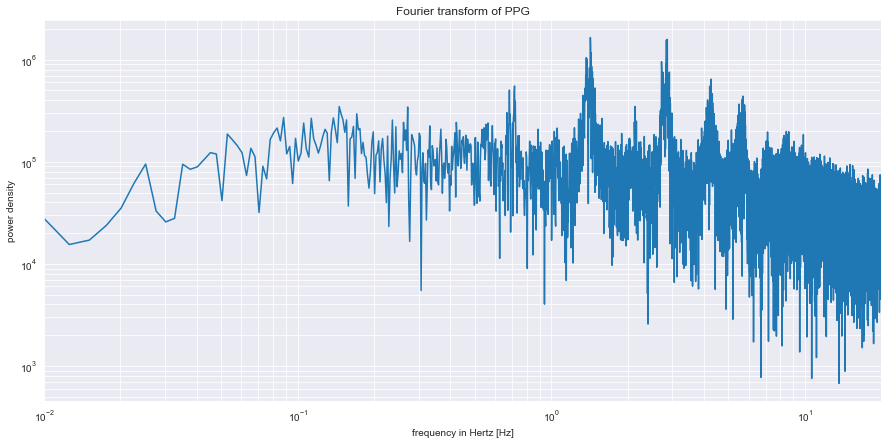

In [30]:
plot_fourier(df.PPG, windows_freq_min=0.01, windows_freq_max=20, log_scale=True)

### Multiple plot

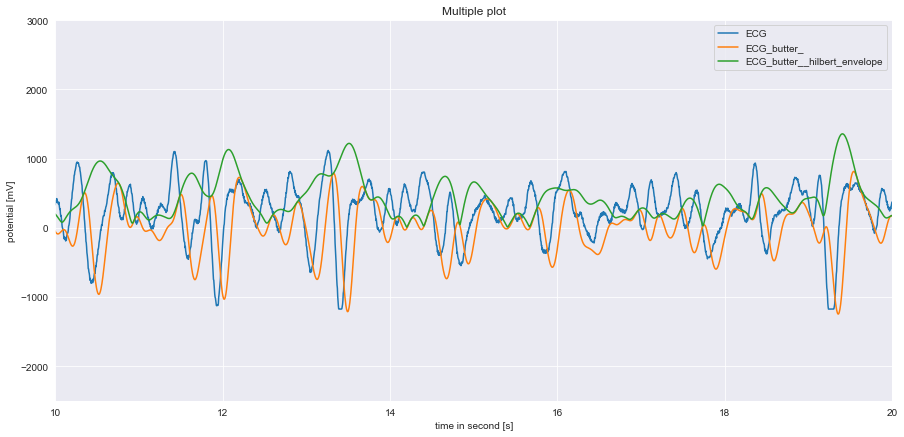

In [32]:
mask = ['ECG','ECG_butter_','ECG_butter__hilbert_envelope']
plot_dataframe(df, windows_low_x=10, windows_high_x=20, windows_low_y=-2500, windows_high_y=3000, mask=mask)

### Cross-correlation of 2 time series

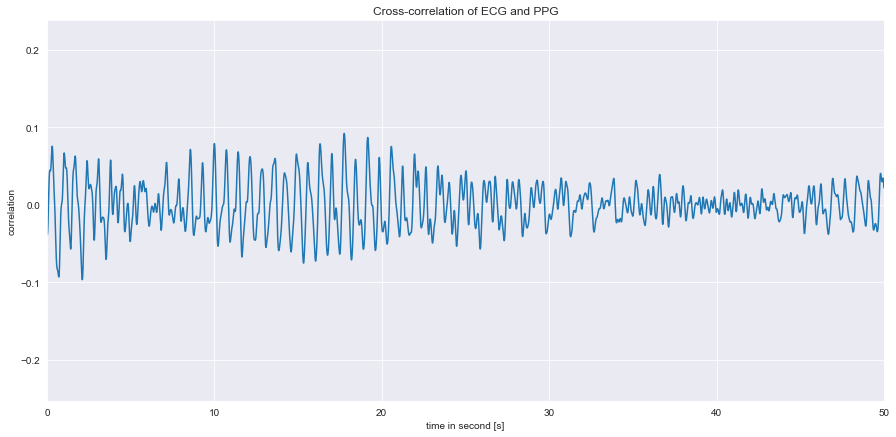

In [33]:
plot_cross_correlation(df,3,0,50)

### Correlation map

In [34]:
plot_correlation_map(df)

,PPG,ECG,PPG_no_trend,ECG_no_trend,PPG_butter_,ECG_butter_,PPG_hilbert_envelope,PPG_hilbert_phase,PPG_hilbert_frequency,ECG_hilbert_envelope,ECG_hilbert_phase,ECG_hilbert_frequency,PPG_butter__hilbert_envelope,PPG_butter__hilbert_phase,PPG_butter__hilbert_frequency,ECG_butter__hilbert_envelope,ECG_butter__hilbert_phase,ECG_butter__hilbert_frequency
PPG,1,0.033,1,-0.013,0.021,0.03,0.72,-0.016,-0.1,-0.015,-0.017,-0.0053,0.072,-0.016,0.047,0.029,-0.016,-0.00083
ECG,0.033,1,0.033,-0.032,0.029,-0.01,0.067,-0.0046,-0.0011,-0.03,-0.0042,-0.011,0.034,-0.0043,0.021,0.039,-0.0041,-0.00079
PPG_no_trend,1,0.033,1,-0.013,0.021,0.03,0.72,-0.016,-0.1,-0.015,-0.017,-0.0053,0.072,-0.016,0.047,0.029,-0.016,-0.00082
ECG_no_trend,-0.013,-0.032,-0.013,1,-0.08,0.34,-0.018,-0.18,0.014,0.77,-0.18,-0.22,-0.11,-0.18,0.043,0.36,-0.18,0.0069
PPG_butter_,0.021,0.029,0.021,-0.08,1,-0.046,0.15,-0.06,-0.069,-0.091,-0.059,0.02,0.66,-0.058,-0.19,-0.032,-0.058,0.0076
ECG_butter_,0.03,-0.01,0.03,0.34,-0.046,1,0.035,-0.19,-0.0056,0.4,-0.19,-0.095,-0.051,-0.19,0.026,0.75,-0.19,-0.09
PPG_hilbert_envelope,0.72,0.067,0.72,-0.018,0.15,0.035,1,-0.034,-0.16,-0.031,-0.034,0.0014,0.14,-0.033,0.075,0.06,-0.033,-0.0056
PPG_hilbert_phase,-0.016,-0.0046,-0.016,-0.18,-0.06,-0.19,-0.034,1,0.029,-0.24,1,0.067,-0.087,1,-0.0053,-0.25,1,-0.015
PPG_hilbert_frequency,-0.1,-0.0011,-0.1,0.014,-0.069,-0.0056,-0.16,0.029,1,0.022,0.028,-0.0091,-0.097,0.029,-0.018,-0.017,0.029,0.0024
ECG_hilbert_envelope,-0.015,-0.03,-0.015,0.77,-0.091,0.4,-0.031,-0.24,0.022,1,-0.24,-0.3,-0.13,-0.24,0.045,0.48,-0.24,0.01


### Peaks detection

According to [American Heart Association](https://www.heart.org/en/) we have those repartition:

* 40-60 bpm average for well-trained athletes, no exercise (lower than the average people).
* ~225 bpm as maximum.

For simplicity we will set the limits of 60-225 bpm which is equivalent to:

$$ T_{\min} = \frac{60}{60} = 1 \text{ s} \Longrightarrow f_{\min} = \frac{1}{T} = 1 \text{ Hz}$$
$$ T_{\max} = \frac{60}{225} = \frac{4}{15} \sim 0.26 \text{ s} \Longrightarrow f_{\max} = \frac{1}{T} = 3.75 \text{ Hz}$$

Therefore we have the theoretical minimal and maximal distance of the heart beat rate. In our case we know that for all the data the frequency sampling is set to 256.

$$ \text{distance}_{\max} = T_{\min} \times 256 = 256 $$
$$ \text{distance}_{\min} = T_{\max} \times 256 \sim 68.26 \Longrightarrow 68$$

We also have the average value: $\text{distance}_{\text{mean}} = 162$. Mind that these are not magic values that will work with all datasets (only here to give a hint).

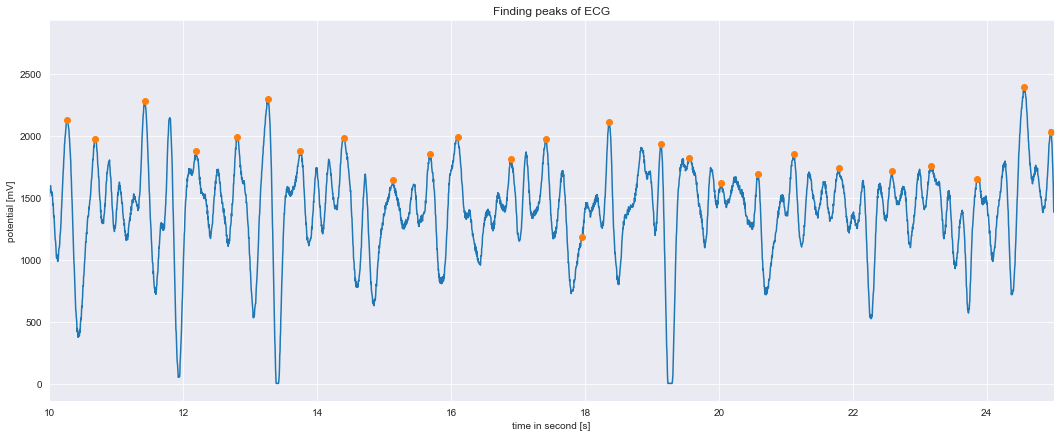

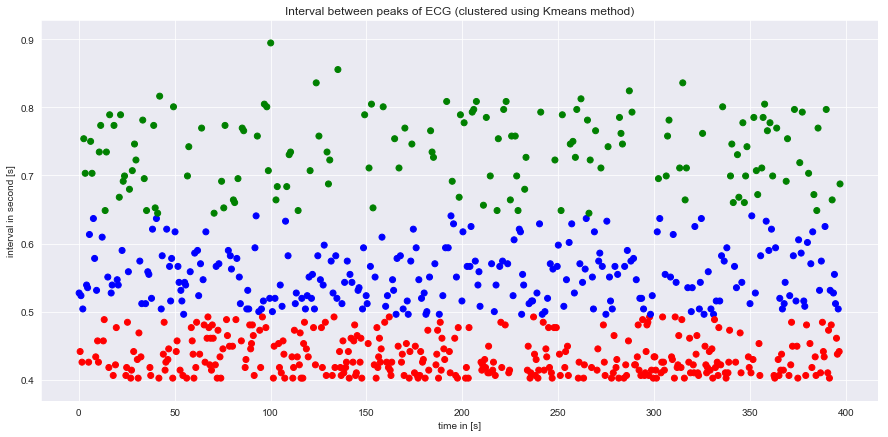

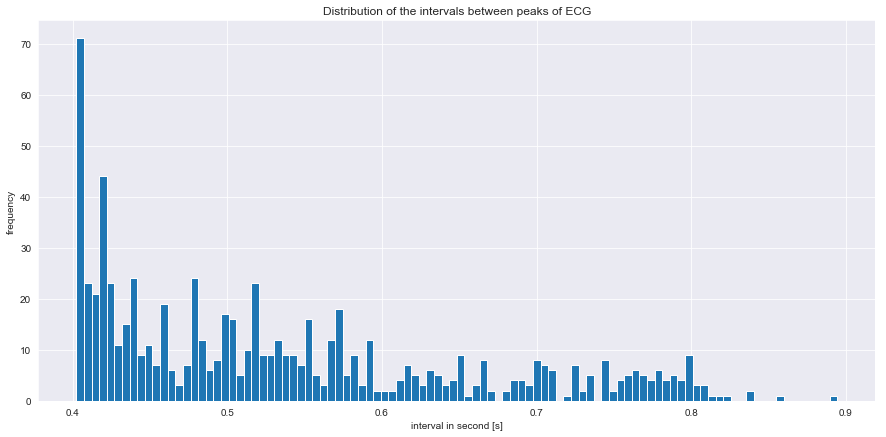

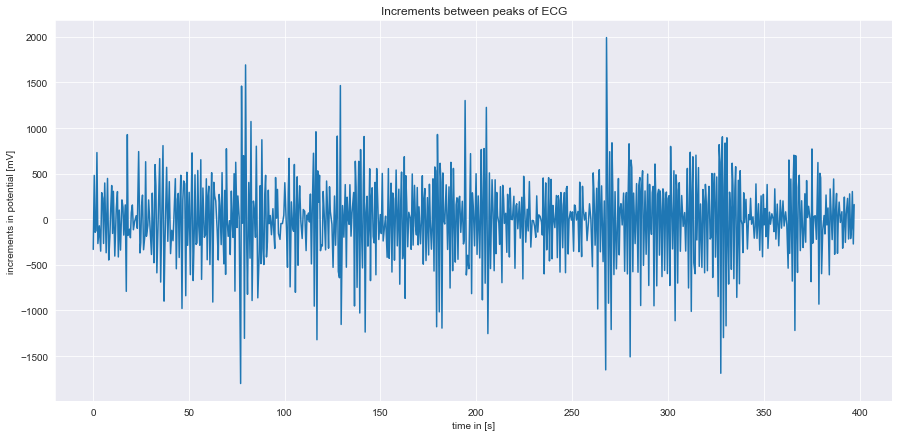

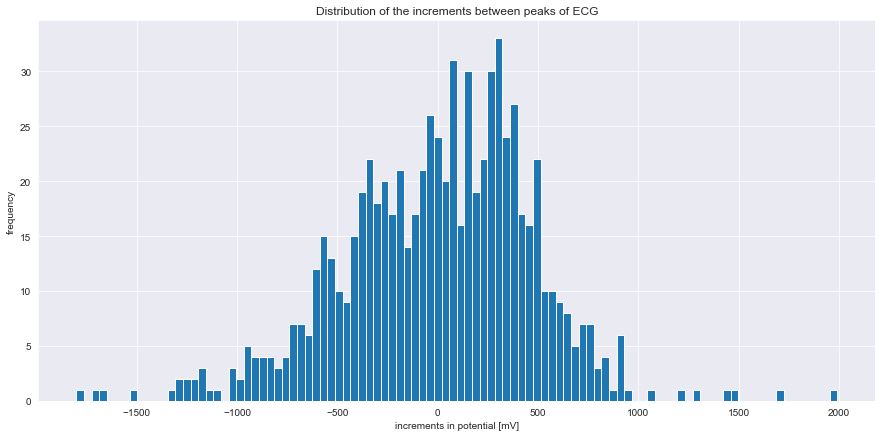

In [81]:
peaks_ECG, interval_ECG, increment_ECG = plot_peak(df.ECG, .4, windows_low_x=10, windows_high_x=25)

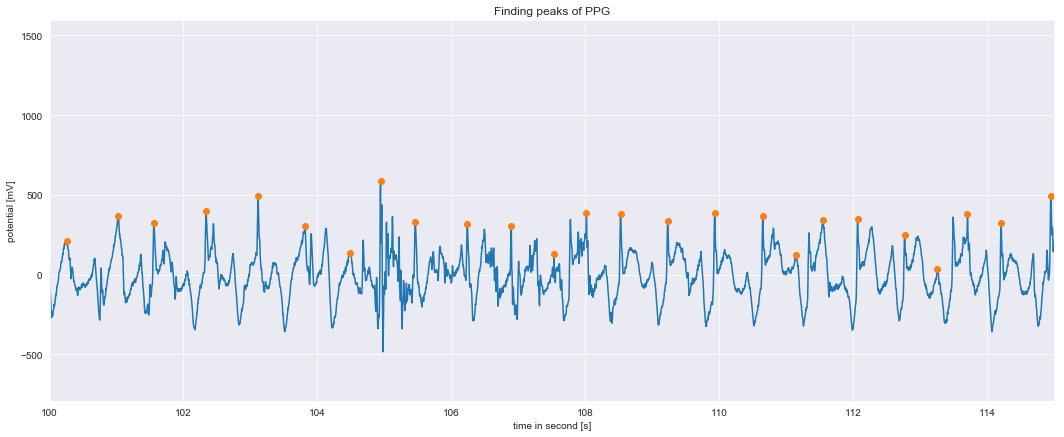

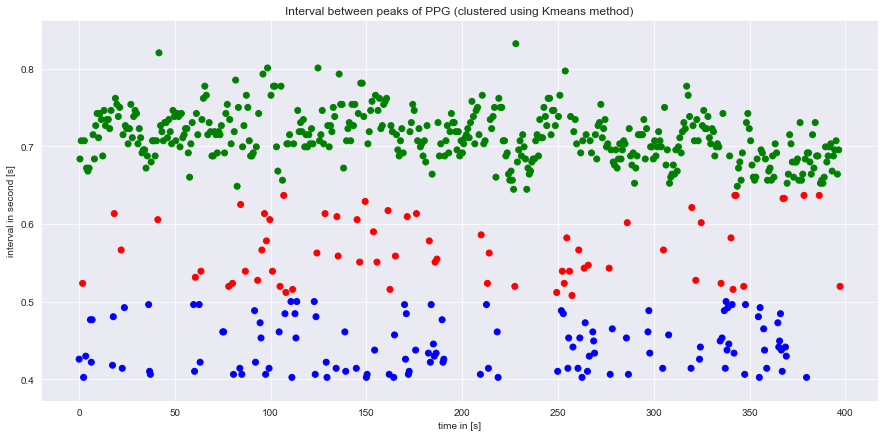

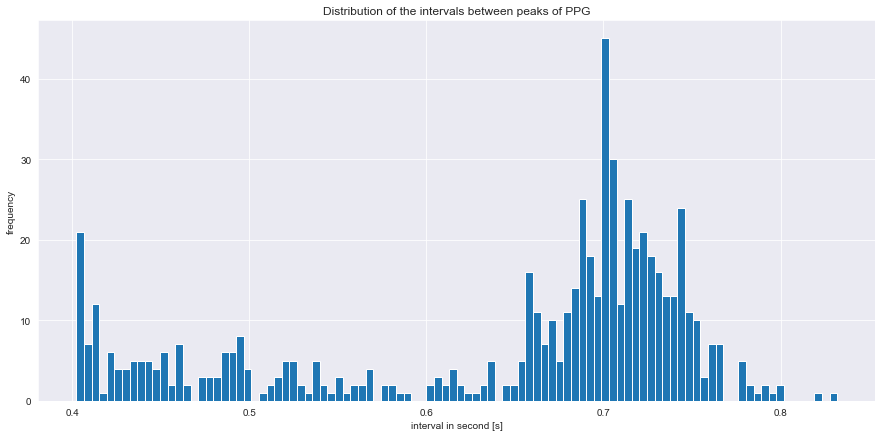

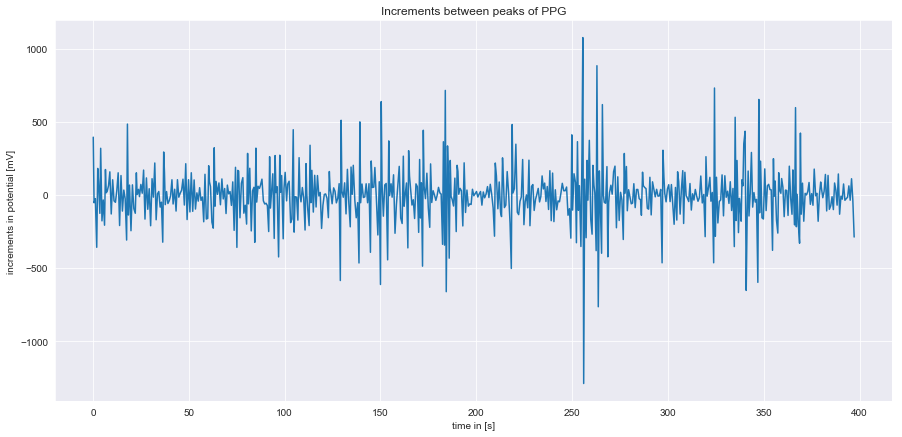

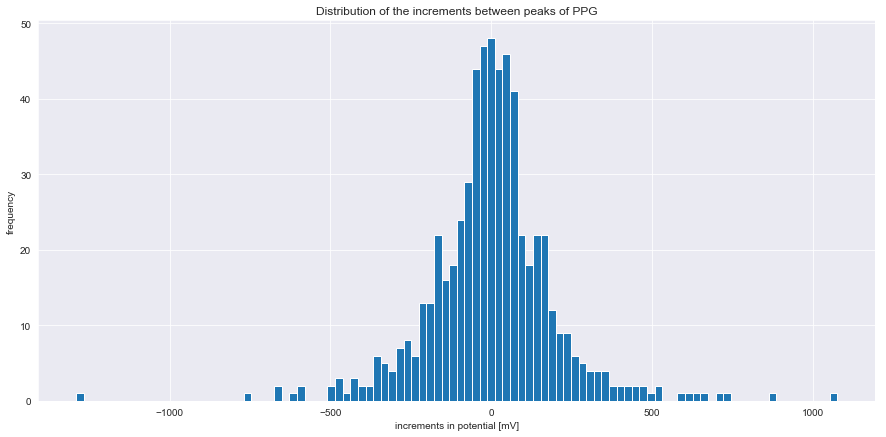

In [80]:
peaks_PPG, interval_PPG, increment_PPG = plot_peak(df.PPG, .4, windows_low_x=100, windows_high_x=115)

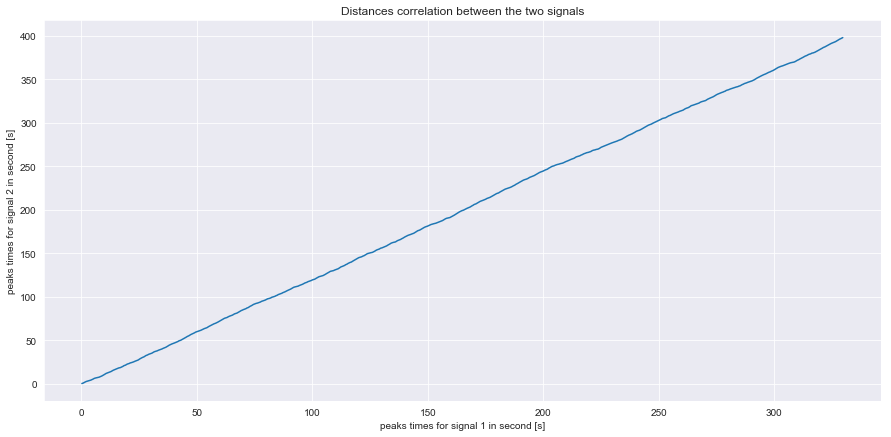

distance measure based on correlation between the two vectors:  6.418417133680077e-05
correlation matrix: 
 [[1.         0.99993582]
 [0.99993582 1.        ]]
spearman correlation:  SpearmanrResult(correlation=1.0, pvalue=0.0)


In [85]:
plot_peak_corr(peaks_ECG,peaks_PPG)

In [87]:
def plot(data1,data2, windows_low_x=None, windows_high_x=None, distance=None):
    '''
    Finding peaks with scipy package
    '''
    
    #####################
    ### finding peaks ###
    #####################
    
    peaks1, properties = find_peaks(data1, distance=distance)
    plt.figure(figsize=(15, 7))
    time1 = np.linspace(0, np.shape(data1)[0] / frequency_sampling, np.shape(data1)[0])
    plt.plot(time1, data1,label='ECG')
    plt.plot(time1[peaks1], data1[peaks1], "o", label='ECG')
    
    peaks2, properties = find_peaks(data2, distance=distance)
    time2 = np.linspace(0, np.shape(data2)[0] / frequency_sampling, np.shape(data2)[0])
    plt.plot(time2, data2,label='PPG')
    plt.plot(time2[peaks2], data2[peaks2],"o",label='PPG')
    if windows_low_x != None and windows_high_x != None:
        plt.xlim(windows_low_x, windows_high_x)
    elif windows_low_x != None:
        plt.xlim(left=windows_low_x)
    elif windows_high_x != None:
        plt.xlim(right=windows_high_x)
    plt.title("Finding peaks ")
    plt.xlabel('time in second [s]')
    plt.ylabel('potential [mV]')
    plt.legend()
    plt.show()
    
        
    ########################################
    ### computing distance between peaks ###
    ########################################
    
    distance1 = peaks1[1:] - peaks1[:-1] 
    distance2 = peaks2[1:] - peaks2[:-1] 

    
    
    ################
    ### Plotting ###
    ################

    plt.figure(figsize=(15, 7))
    plt.scatter(np.arange(len(distance1)) / frequency_sampling,
                distance1 / frequency_sampling, label='ECG')
   
    plt.scatter(np.arange(len(distance2)) / frequency_sampling,
                distance2 / frequency_sampling, label='PPG')
    plt.title("Distance between peaks")
    plt.xlabel('peaks indices')
    plt.ylabel('distance in second [s]')
    plt.legend()

    plt.show()
    
    plt.figure(figsize=(15, 7))
    plt.hist(distance1 / frequency_sampling , bins=200, label='ECG')
    plt.hist(distance2 / frequency_sampling , bins=200,label='PPG')

    plt.title("Distribution of the distance between peaks ")
    plt.xlabel('distance in second [s]')
    plt.ylabel('frequency')
    plt.legend()

    plt.show()
    


In [86]:
plot(df.ECG, df.PPG, windows_low_x=100, windows_high_x=115, distance=100)

NameError: name 'plot' is not defined